In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests
import numpy as np
import polars as pl
import polars.selectors as cs
from dataclasses import dataclass
from typing import Optional
from functools import cache

from synthete_analysis.constants import CONCENTRATED_IN_OIL, METRICS_FOR_ANALYSIS
from synthete_analysis.retrieval import query_imf
from synthete_analysis.cleanup import normalize_metric_dict, add_all_years

In [3]:
all_countries = query_imf("https://www.imf.org/external/datamapper/api/v1/countries")[
    "countries"
]
indicators = query_imf("https://www.imf.org/external/datamapper/api/v1/indicators")['indicators']
groups = query_imf("https://www.imf.org/external/datamapper/api/v1/groups")["groups"]

In [115]:
all_countries

{'ABW': {'label': 'Aruba'},
 'AFG': {'label': 'Afghanistan'},
 'AGO': {'label': 'Angola'},
 'AIA': {'label': 'Anguilla'},
 'ALB': {'label': 'Albania'},
 'ARE': {'label': 'United Arab Emirates'},
 'ARG': {'label': 'Argentina'},
 'ARM': {'label': 'Armenia'},
 'ASM': {'label': 'American Samoa'},
 'ATG': {'label': 'Antigua and Barbuda'},
 'AUS': {'label': 'Australia'},
 'AUT': {'label': 'Austria'},
 'AZE': {'label': 'Azerbaijan'},
 'BDI': {'label': 'Burundi'},
 'BEL': {'label': 'Belgium'},
 'BEN': {'label': 'Benin'},
 'BFA': {'label': 'Burkina Faso'},
 'BGD': {'label': 'Bangladesh'},
 'BGR': {'label': 'Bulgaria'},
 'BHR': {'label': 'Bahrain'},
 'BHS': {'label': 'Bahamas, The'},
 'BIH': {'label': 'Bosnia and Herzegovina'},
 'BLR': {'label': 'Belarus'},
 'BLZ': {'label': 'Belize'},
 'BMU': {'label': 'Bermuda'},
 'BOL': {'label': 'Bolivia'},
 'BRA': {'label': 'Brazil'},
 'BRB': {'label': 'Barbados'},
 'BRN': {'label': 'Brunei Darussalam'},
 'BTN': {'label': 'Bhutan'},
 'BWA': {'label': 'Botsw

In [95]:
indicators

{'NGDP_RPCH': {'label': 'Real GDP growth',
  'description': "Gross domestic product is the most commonly used single measure of a country's overall economic activity. It represents the total value at constant prices of final goods and services produced within a country during a specified time period, such as one year.",
  'source': 'World Economic Outlook (April 2025)',
  'unit': 'Annual percent change',
  'dataset': 'WEO'},
 'NGDPD': {'label': 'GDP, current prices',
  'description': "Gross domestic product is the most commonly used single measure of a country's overall economic activity. It represents the total value at current prices of final goods and services produced within a country during a specified time period, such as one year.",
  'source': 'World Economic Outlook (April 2025)',
  'unit': 'Billions of U.S. dollars',
  'dataset': 'WEO'},
 'NGDPDPC': {'label': 'GDP per capita, current prices\n',
  'description': "Gross domestic product is the most commonly used single measure 

In [11]:
indicators['PPPPC']

{'label': 'GDP per capita, current prices',
 'description': 'Gross domestic product (GDP) is the most commonly used single measure of a country\'s overall economic activity. Per capita GDP represents the total value in PPP terms of final goods and services produced within a country during a specified time period divided by the average population for the same one year.\n\nPurchasing Power Parity (PPP) is a theory which relates changes in the nominal exchange rate between two countries currencies to changes in the countries\' price levels. More information on PPP methodology can be found on the World Economic Outlook FAQ - <a href="http://www.imf.org/external/pubs/ft/weo/faq.htm#q4d" target="new">click here</a>',
 'source': 'World Economic Outlook (April 2025)',
 'unit': 'Purchasing power parity; international dollars per capita',
 'dataset': 'WEO'}

# Justification for using PPPPC instead of NGDPDPC
should I use PPPPC instead of NGDPDPC for step Calculate each country's average GDP per capita (1990-2019).?

This is a fantastic and very important question. The choice between NGDPDPC and PPPPC for the initial sorting step fundamentally changes the nature of the "similarity" you are measuring for your peers.

There is no single "right" answer, but there is a more conceptually appropriate choice based on the goal of the synthetic peer methodology. Let's break down the implications of each option.
Option 1: Use NGDPDPC (GDP per capita, current US$)

    What it measures: The average market-exchange rate converted income of a country. It reflects the country's ability to engage with the global market (buy imported goods, service foreign debt, etc.).

    Pros:

        Relevance for fiscal policy: Government debt is often denominated in foreign currency (e.g., US dollars). The government's capacity to earn foreign currency through exports and taxes to service this debt is better reflected by NGDPDPC.

        Reflects global market integration: It captures a country's position in the global economic hierarchy as defined by market forces.

    Cons:

        Volatile: Highly sensitive to exchange rate fluctuations, which can be dramatic and not necessarily tied to real economic performance.

        Doesn't reflect domestic living costs: A country with a low cost of living might have a lower NGDPDPC but a relatively higher standard of living than the number suggests.

Option 2: Use PPPPC (GDP per capita, PPP)

    What it measures: The average purchasing power of income within a country's domestic economy. It adjusts for differences in the cost of living and is a better measure of the actual standard of living and domestic economic structure.

    Pros:

        Better measure of domestic economy: It more accurately reflects the size and structure of the domestic tax base, which is crucial for fiscal capacity.

        Stable: Not affected by exchange rate volatility, giving a smoother, more stable measure of economic level over time.

        Reflects real economic size: China and India have much larger economies measured at PPP than at market rates.

    Cons:

        Less relevant for external debt: A government's ability to service dollar-denominated debt is not directly related to its PPP-adjusted GDP.

Recommendation: Which One to Use?

The paper's methodology is designed to find countries that are structurally similar but have achieved better performance.

For this goal, using PPPPC for the initial sorting is the stronger and more conceptually robust choice.

Why?

    Structural Similarity: The core idea of "similarity" should be based on the internal structure and development of the economy—the productivity of its workers, the sophistication of its industries, and the size of its domestic market. PPPPC is a far superior measure for this. It filters out the noise of exchange rates and focuses on the real economic engine.

    Policy Lessons: The lessons you learn from synthetic peers are likely about domestic policy—institutions, education, infrastructure, industrial policy. These affect the real, productive capacity of the economy, which is best captured by PPP measures.

    Consistency with Growth Metric: You are already using PPPPC to measure performance. Using it for the initial level ensures you are comparing "apples to apples." You are finding countries that started with a similar real economic level and then seeing which ones achieved the best real growth.

Conclusion:

While using NGDPDPC is defensible (especially if your analysis is specifically about external debt sustainability), for the general purpose of identifying synthetic peers based on economic structure and performance, you should use PPPPC for both steps.

Final Algorithm Recommendation:

    Calculate Average Level (for Sorting):

        Use PPPPC (Average 1990-2019)

    Find Neighborhood:

        Sort countries by average PPPPC. Select 20 above and 20 below.

    Calculate Performance (for Ranking):

        Use PPPPC to calculate growth: (PPPPC_2019 / PPPPC_1990) - 1

This approach ensures your peer groups are formed based on real economic similarity and ranked by real economic performance, which is the most meaningful comparison for policy analysis.

In [171]:
# retrieval
METRIC = "PPPPC"
gdp_per_capita = query_imf(f"https://www.imf.org/external/datamapper/api/v1/{METRIC}")[
    "values"
][f"{METRIC}"]

# cleanup
gdp_per_capita_df = pl.DataFrame(normalize_metric_dict(gdp_per_capita))
gdp_per_capita_df = add_all_years(gdp_per_capita_df)
gdp_per_capita_df = (
    gdp_per_capita_df.filter(
        (pl.col("year") >= 1990)
        & (pl.col("year") <= 2019)
        & (pl.col("country").is_in(all_countries.keys()))
        & (~pl.col("country").is_in(CONCENTRATED_IN_OIL))
    )
    .sort("year")
    .with_columns(pl.col("value").fill_null(strategy="forward").over("country"))
)
# fill forward produces results 4/8 compared to papers, backwards 3/8

# analysis
average_gdp_per_capita_df = (
    gdp_per_capita_df.group_by(pl.col("country"))
    .agg(pl.col("value").mean()).rename({"value": "average_gdp_per_capita"})
)
# important that index is added last 

In [172]:
gdp_per_capita['ZWE']

{'1998': 2812.986,
 '1999': 2828.804,
 '2000': 2777.836,
 '2001': 2834.765,
 '2002': 2664.11,
 '2003': 2274.309,
 '2004': 2172.226,
 '2005': 2056.724,
 '2006': 2014.11,
 '2007': 1993.349,
 '2008': 1688.888,
 '2009': 1808.571,
 '2010': 2176.304,
 '2011': 2512.216,
 '2012': 2847.536,
 '2013': 2874.793,
 '2014': 2919.43,
 '2015': 2937.466,
 '2016': 2926.183,
 '2017': 3070.167,
 '2018': 2838.724,
 '2019': 3251.507,
 '2020': 3499.647,
 '2021': 4182.605,
 '2022': 4660.594,
 '2023': 4965.087,
 '2024': 5075.699,
 '2025': 5407.359,
 '2026': 5661.688,
 '2027': 5851.14,
 '2028': 6051.366,
 '2029': 6246.941,
 '2030': 6450.939}

In [173]:
gdp_per_capita_df.filter(pl.col("country") == "UVK")

country,year,value
str,i64,f64
"""UVK""",1990,null
"""UVK""",1991,null
"""UVK""",1992,null
"""UVK""",1993,null
"""UVK""",1994,null
…,…,…
"""UVK""",2015,9638.614
"""UVK""",2016,10346.144
"""UVK""",2017,10976.415


In [174]:
# analysis 
real_gdp_per_capita_growth_df = (
    gdp_per_capita_df.filter(pl.col("year").is_between(1990, 2019))
    .group_by("country")
    .agg([
        # Get first and last non-null values in the period
        pl.col("value").filter(pl.col("year") == 1990).first().alias("start_value"),
        pl.col("value").filter(pl.col("year") == 2019).first().alias("end_value"),
        # Count available years to ensure sufficient data
        pl.col("value").filter(pl.col("value").is_not_null()).count().alias("valid_years")
    ])
    .filter(
        (pl.col("start_value").is_not_null()) & 
        (pl.col("end_value").is_not_null()) &
        (pl.col("start_value") > 0) &  # Avoid division by zero
        (pl.col("valid_years") >= 2)   # At least 2 data points
    )
    .with_columns([
        # Calculate CAGR: (end/start)^(1/years) - 1
        ((pl.col("end_value") / pl.col("start_value")) ** (1/(2019-1990)) - 1).alias("cagr")
    ])
    .select(["country", "cagr"])
)

In [175]:
all_data_df = average_gdp_per_capita_df.join(real_gdp_per_capita_growth_df, on="country")

In [176]:
all_data_df

country,average_gdp_per_capita,cagr
str,f64,f64
"""JOR""",7714.044433,0.023217
"""GTM""",6833.832233,0.035338
"""PRY""",8922.0549,0.033595
"""COM""",2487.9221,0.019427
"""STP""",2435.087367,0.038656
…,…,…
"""MAR""",5143.9457,0.04076
"""BGR""",13143.2887,0.034914
"""BWA""",10242.743033,0.031811


In [179]:
def get_synthete_peers(target_country, df):
    df = df.sort("average_gdp_per_capita").with_row_index(name="index") # row index used to get top 20 and bottom 20
    target_row = df.filter(pl.col("country") == target_country)
    if target_row.is_empty():
        return []

    target_index = target_row.select("index").item()

    # Get 20 below and 20 above (handling edge cases with slice)
    lower_neighbors = df.filter((pl.col("index") < target_index)).tail(20)
    upper_neighbors = df.filter((pl.col("index") > target_index)).head(20)

    # # Select top 5 by growth, drop the top 1
    # lower5 = lower_neighbors.sort("cagr", descending=True).head(5)
    # upper5 = upper_neighbors.sort("cagr", descending=True).head(5)

    #     # Drop the *single* fastest grower (outlier) in each half
    # lower_best = lower5.sort("cagr", descending=True).tail(4)
    # upper_best = upper5.sort("cagr", descending=True).tail(4)
    
    lower_best = lower_neighbors.sort("cagr", descending=True).slice(
        1, 4
    )  # 5-1 = 4 remaining
    upper_best = upper_neighbors.sort("cagr", descending=True).slice(1, 4)

    synthete_peers = (
        lower_best.select("country").to_series().to_list()
        + upper_best.select("country").to_series().to_list()
    )
    return synthete_peers

In [180]:
# Example: Get synthete peers for "SVN"
peers = get_synthete_peers("JAM",all_data_df)
for country in peers:
    print(all_countries[country])

{'label': 'Vietnam'}
{'label': 'Bhutan'}
{'label': 'Sri Lanka'}
{'label': 'Cabo Verde'}
{'label': 'Dominican Republic'}
{'label': 'Mauritius'}
{'label': 'Thailand'}
{'label': 'Lebanon'}


In [ ]:
{'label': 'Vietnam'}
{'label': 'Bhutan'}
{'label': 'Sri Lanka'}
{'label': 'Cabo Verde'}
{'label': 'Dominican Republic'}
{'label': 'Mauritius'}
{'label': 'Thailand'}
{'label': 'Lebanon'}

In [76]:
all_data_df = all_data_df.sort("average_gdp_per_capita").with_row_index(name="index")

In [126]:
all_data_df

country,average_gdp_per_capita,cagr
str,f64,f64
"""STP""",2435.087367,0.038656
"""SEN""",2260.2798,0.031569
"""BRB""",14035.807833,0.022815
"""MAR""",5143.9457,0.04076
"""PER""",7463.932433,0.052029
…,…,…
"""ZMB""",2218.653233,0.027904
"""SLV""",5998.6574,0.039364
"""ESP""",28854.690667,0.035053


In [159]:
all_data_df.filter(pl.col("country") == "SRB")

country,average_gdp_per_capita,cagr
str,f64,f64
"""SRB""",11176.511567,0.040004


In [139]:
"KOS" in all_countries.keys()

True

# you're here SRB and XKX missing from all_data_df.  its missing because those countries dont have 1990 data and we're filling forward.  author does some kind of patch for missing data might want to explore that also 4/8 is pretty close

In [100]:
target_row = all_data_df.filter(pl.col("country") == "JAM")

In [101]:
target_row

country,average_gdp_per_capita,cagr
str,f64,f64
"""JAM""",4023.807567,0.037794


In [79]:
target_index = target_row.select("index").item()

In [80]:
target_index

65

In [81]:
lower_neighbors = all_data_df.filter((pl.col("index") < target_index)).tail(20)

In [82]:
lower_neighbors

index,country,average_gdp_per_capita,cagr
u32,str,f64,f64
45,"""VNM""",4630.4988,0.078499
46,"""CPV""",4877.636233,0.057361
47,"""SYR""",5125.4937,0.027982
48,"""MAR""",5143.9457,0.04076
49,"""BOL""",5332.1143,0.041861
…,…,…,…
60,"""BLZ""",7237.5579,0.036392
61,"""PER""",7463.932433,0.052029
62,"""GUY""",7492.5202,0.053604


In [83]:
upper_neighbors = all_data_df.filter((pl.col("index") > target_index)).head(20)

In [84]:
upper_neighbors

index,country,average_gdp_per_capita,cagr
u32,str,f64,f64
66,"""EGY""",8257.881633,0.043039
67,"""DMA""",8543.763,0.040641
68,"""FJI""",8741.7601,0.034609
69,"""VCT""",8777.4392,0.043863
70,"""PRY""",8922.0549,0.033595
…,…,…,…
81,"""BGR""",13143.2887,0.034914
82,"""BRB""",14035.807833,0.022815
83,"""MDV""",14090.2214,0.06436


In [85]:
lower_best = lower_neighbors.sort("cagr", descending=True).slice(
        1, 4
    )  # 5-1 = 

In [86]:
lower_best

index,country,average_gdp_per_capita,cagr
u32,str,f64,f64
45,"""VNM""",4630.4988,0.078499
50,"""BTN""",5607.724567,0.070506
57,"""LKA""",6927.5847,0.065782
46,"""CPV""",4877.636233,0.057361


In [87]:
 upper_best = upper_neighbors.sort("cagr", descending=True).slice(1, 4)

In [88]:
upper_best

index,country,average_gdp_per_capita,cagr
u32,str,f64,f64
72,"""DOM""",9830.0648,0.060628
80,"""MUS""",12810.1491,0.055486
77,"""THA""",10910.088933,0.055249
85,"""LBN""",14486.09,0.051348


In [2]:
# Retrieve and process government primary balance data for 1990–2019
# Ensure all dependencies are imported (for standalone cell execution)
from synthete_analysis.retrieval import query_imf
from synthete_analysis.cleanup import normalize_metric_dict, add_all_years
from synthete_analysis.constants import CONCENTRATED_IN_OIL
import polars as pl

# Check the correct indicator from 'indicators' to use (likely 'pb' = primary balance)
pb_metric = 'pb'  # Confirm this label in the indicators dictionary
primary_balance = query_imf(f"https://www.imf.org/external/datamapper/api/v1/{pb_metric}")["values"][pb_metric]

# Cleanup: normalize and add year columns, restrict to available and valid years/countries
primary_balance_df = pl.DataFrame(normalize_metric_dict(primary_balance))
primary_balance_df = add_all_years(primary_balance_df)
primary_balance_df = (
    primary_balance_df.filter(
        (pl.col("year") >= 1990)
        & (pl.col("year") <= 2019)
        & (pl.col("country").is_in(all_countries.keys()))
        & (~pl.col("country").is_in(CONCENTRATED_IN_OIL))
    )
    .sort("year")
    .with_columns(pl.col("value").fill_null(strategy="forward").over("country"))
)
# Compute the average primary balance for each country in this period
average_primary_balance_df = (
    primary_balance_df.group_by(pl.col("country"))
    .agg(pl.col("value").mean()).rename({"value": "average_primary_balance"})
)

NameError: name 'all_countries' is not defined

In [4]:
# Calculate average primary balance (pb, percent of GDP) for 1990–2019
from synthete_analysis.retrieval import query_imf
from synthete_analysis.cleanup import normalize_metric_dict, add_all_years
from synthete_analysis.constants import CONCENTRATED_IN_OIL
import polars as pl

pb_metric = 'pb'  # Government primary balance, percent of GDP
primary_balance = query_imf(f"https://www.imf.org/external/datamapper/api/v1/{pb_metric}")["values"][pb_metric]

# Normalize, handle years/countries (forward fill), filter same as for GDP analysis
df_pb = pl.DataFrame(normalize_metric_dict(primary_balance))
df_pb = add_all_years(df_pb)
df_pb = (
    df_pb.filter(
        (pl.col("year") >= 1990)
        & (pl.col("year") <= 2019)
        & (pl.col("country").is_in(all_countries.keys()))
        & (~pl.col("country").is_in(CONCENTRATED_IN_OIL))
    )
    .sort("year")
    .with_columns(pl.col("value").fill_null(strategy="forward").over("country"))
)
# Calculate average primary balance per country
average_primary_balance_df = (
    df_pb.group_by(pl.col("country"))
    .agg(pl.col("value").mean()).rename({"value": "average_primary_balance"})
)
# Display and quick visual EDA
average_primary_balance_df.head(10)

country,average_primary_balance
str,f64
"""BEN""",-0.421839
"""FJI""",1.126535
"""ISR""",0.747342
"""KIR""",1.253615
"""TUR""",1.806599
"""SVN""",-1.029042
"""ESP""",-0.868251
"""NAM""",-0.838311
"""SWE""",1.488134


In [6]:
# Reconstruct all_data_df from the latest available steps
# Ensure supporting imports and data sources are available
import polars as pl
from synthete_analysis.retrieval import query_imf
from synthete_analysis.cleanup import normalize_metric_dict, add_all_years
from synthete_analysis.constants import CONCENTRATED_IN_OIL, METRICS_FOR_ANALYSIS

# Re-run the code that builds all_data_df so this variable exists for joining
METRIC = "PPPPC"
gdp_per_capita = query_imf(f"https://www.imf.org/external/datamapper/api/v1/{METRIC}")["values"][f"{METRIC}"]
gdp_per_capita_df = pl.DataFrame(normalize_metric_dict(gdp_per_capita))
gdp_per_capita_df = add_all_years(gdp_per_capita_df)
gdp_per_capita_df = (
    gdp_per_capita_df.filter(
        (pl.col("year") >= 1990)
        & (pl.col("year") <= 2019)
        & (pl.col("country").is_in(all_countries.keys()))
        & (~pl.col("country").is_in(CONCENTRATED_IN_OIL))
    )
    .sort("year")
    .with_columns(pl.col("value").fill_null(strategy="forward").over("country"))
)
average_gdp_per_capita_df = (
    gdp_per_capita_df.group_by(pl.col("country"))
    .agg(pl.col("value").mean()).rename({"value": "average_gdp_per_capita"})
)
real_gdp_per_capita_growth_df = (
    gdp_per_capita_df.filter(pl.col("year").is_between(1990, 2019))
    .group_by("country")
    .agg([
        pl.col("value").filter(pl.col("year") == 1990).first().alias("start_value"),
        pl.col("value").filter(pl.col("year") == 2019).first().alias("end_value"),
        pl.col("value").filter(pl.col("value").is_not_null()).count().alias("valid_years")
    ])
    .filter(
        (pl.col("start_value").is_not_null()) & 
        (pl.col("end_value").is_not_null()) &
        (pl.col("start_value") > 0) &
        (pl.col("valid_years") >= 2)
    )
    .with_columns([
        ((pl.col("end_value") / pl.col("start_value")) ** (1/(2019-1990)) - 1).alias("cagr")
    ])
    .select(["country", "cagr"])
)
all_data_df = average_gdp_per_capita_df.join(real_gdp_per_capita_growth_df, on="country")
all_data_df = all_data_df.sort("average_gdp_per_capita").with_row_index(name="index")

# Now retry the join of average primary balance with all_data_df as intended
all_data_full_df = all_data_df.join(average_primary_balance_df, on="country", how="left")
# Show top rows for QC
display(all_data_full_df.head(10))
all_data_full_df.describe()

index,country,average_gdp_per_capita,cagr,average_primary_balance
u32,str,f64,f64,f64
0,"""BDI""",687.7703,0.005309,-4.407897
1,"""MOZ""",708.5579,0.057616,-1.913062
2,"""COD""",819.593133,0.001926,0.297757
3,"""NER""",877.8257,0.024817,-0.580935
4,"""MWI""",883.1362,0.034679,null
5,"""CAF""",928.270233,0.008003,-0.773374
6,"""ETH""",1091.7075,0.060015,-2.715644
7,"""RWA""",1119.2286,0.051044,-1.36305
8,"""BFA""",1272.4861,0.046408,-2.102977


statistic,index,country,average_gdp_per_capita,cagr,average_primary_balance
str,f64,str,f64,f64,f64
"""count""",131.0,"""131""",131.0,131.0,112.0
"""null_count""",0.0,"""0""",0.0,0.0,19.0
"""mean""",65.0,null,13844.618618,0.039913,0.099432
"""std""",37.960506,null,14464.870953,0.016104,2.019188
"""min""",0.0,"""ABW""",687.7703,0.001926,-5.164684
"""25%""",33.0,null,2739.910133,0.031228,-1.037084
"""50%""",65.0,null,8257.881633,0.036895,-0.175833
"""75%""",98.0,null,19139.371667,0.051348,1.173316
"""max""",130.0,"""ZMB""",84412.6833,0.109207,7.350894


In [ ]:
# Join average primary balance to main analysis dataset
all_data_full_df = all_data_df.join(average_primary_balance_df, on="country", how="left")
# Show top rows for QC
display(all_data_full_df.head(10))
all_data_full_df.describe()

NameError: name 'all_data_df' is not defined

In [7]:
indicators

{'NGDP_RPCH': {'label': 'Real GDP growth',
  'description': "Gross domestic product is the most commonly used single measure of a country's overall economic activity. It represents the total value at constant prices of final goods and services produced within a country during a specified time period, such as one year.",
  'source': 'World Economic Outlook (October 2025)',
  'unit': 'Annual percent change',
  'dataset': 'WEO'},
 'NGDPD': {'label': 'GDP, current prices',
  'description': "Gross domestic product is the most commonly used single measure of a country's overall economic activity. It represents the total value at current prices of final goods and services produced within a country during a specified time period, such as one year.",
  'source': 'World Economic Outlook (October 2025)',
  'unit': 'Billions of U.S. dollars',
  'dataset': 'WEO'},
 'NGDPDPC': {'label': 'GDP per capita, current prices\n',
  'description': "Gross domestic product is the most commonly used single meas

In [8]:
# Check missingness of average primary balance (pb) in all_data_full_df
import matplotlib.pyplot as plt

# 1. Count missing and present values
total_countries = all_data_full_df.shape[0]
pb_missing_count = all_data_full_df['average_primary_balance'].null_count()
pb_present_count = total_countries - pb_missing_count

print(f"Primary balance not missing for {pb_present_count}/{total_countries} countries ({pb_present_count/total_countries:.0%})")
print(f"Primary balance missing for {pb_missing_count}/{total_countries} countries ({pb_missing_count/total_countries:.0%})")

# 2. Visualize missingness by country (left bar=missing, right bar=present)
plt.figure(figsize=(8, 1))
plt.barh([0], [pb_missing_count], color='red', label='Missing')
plt.barh([0], [pb_present_count], color='green', left=[pb_missing_count], label='Present')
plt.yticks([])
plt.xlabel('Number of countries')
plt.title('Missingness of Primary Balance (1990-2019) across sample')
plt.legend(loc='upper right')
plt.show()

# Optionally: list countries with missing PB
data_missing_pb = all_data_full_df.filter(pl.col('average_primary_balance').is_null())
data_missing_pb.select(['country'])

ModuleNotFoundError: No module named 'matplotlib'

In [9]:
# Quantify missingness of average primary balance (pb) in all_data_full_df
import polars as pl

total_countries = all_data_full_df.shape[0]
pb_missing = all_data_full_df.filter(pl.col('average_primary_balance').is_null())
pb_present = all_data_full_df.filter(pl.col('average_primary_balance').is_not_null())

num_present = pb_present.shape[0]
num_missing = pb_missing.shape[0]
print(f"Primary balance present for {num_present}/{total_countries} countries ({num_present/total_countries:.0%})")
print(f"Primary balance missing for {num_missing}/{total_countries} countries ({num_missing/total_countries:.0%})")

print("Countries missing average primary balance:")
print(pb_missing.select(['country']))

# If too much missingness, suggest a fallback using 'rev', 'exp', 'ie' (see next cell if needed)

Primary balance present for 112/131 countries (85%)
Primary balance missing for 19/131 countries (15%)
Countries missing average primary balance:
shape: (19, 1)
┌─────────┐
│ country │
│ ---     │
│ str     │
╞═════════╡
│ MWI     │
│ MLI     │
│ SLE     │
│ GMB     │
│ NPL     │
│ …       │
│ MUS     │
│ PRI     │
│ MLT     │
│ TWN     │
│ SGP     │
└─────────┘


In [11]:
# Reconstruct primary balance where missing using available revenue, expenditure, and interest indicators from WEO
from synthete_analysis.retrieval import query_imf
from synthete_analysis.cleanup import normalize_metric_dict, add_all_years
from synthete_analysis.constants import CONCENTRATED_IN_OIL
import polars as pl

# Get data for revenue (rev), expenditure (exp), and interest expense (ie), all as % of GDP
def fetch_metric_avg(metric_code, years=(1990, 2019)):
    values = query_imf(f"https://www.imf.org/external/datamapper/api/v1/{metric_code}")['values'][metric_code]
    df = pl.DataFrame(normalize_metric_dict(values))
    df = add_all_years(df)
    df = (
        df.filter(
            (pl.col("year") >= years[0])
            & (pl.col("year") <= years[1])
            & (pl.col("country").is_in(all_countries.keys()))
            & (~pl.col("country").is_in(CONCENTRATED_IN_OIL))
        )
        .sort("year")
        .with_columns(pl.col("value").fill_null(strategy="forward").over("country"))
    )
    avg_df = df.group_by(pl.col("country")).agg(pl.col("value").mean().alias(f"avg_{metric_code}"))
    return avg_df

# Fetch all relevant metrics
avg_rev = fetch_metric_avg('rev')
avg_exp = fetch_metric_avg('exp')
avg_ie = fetch_metric_avg('ie')

# Merge stepwise and avoid suffix collision
temp_merged = avg_rev.join(avg_exp, on="country", how="outer", suffix="_exp")
recon_pb_df = temp_merged.join(avg_ie, on="country", how="outer", suffix="_ie")
# Estimated PB = rev - exp + ie (primary exp = exp - ie, pb = rev - primary exp)
recon_pb_df = recon_pb_df.with_columns((pl.col("avg_rev") - (pl.col("avg_exp") - pl.col("avg_ie"))).alias("recon_primary_balance"))

# Combine with true pb, fill with reconstructed where missing, and output summary for review
all_data_pb_combo = all_data_full_df.join(recon_pb_df.select(["country", "recon_primary_balance"]), on="country", how="left")
all_data_pb_combo = all_data_pb_combo.with_columns(
    pl.col("average_primary_balance").fill_null(pl.col("recon_primary_balance")).alias("pb_final")
)

# Show summary of how many pb_final values are now missing/filled
pb_final_missing = all_data_pb_combo.filter(pl.col("pb_final").is_null())
pb_final_present = all_data_pb_combo.filter(pl.col("pb_final").is_not_null())
print(f"PB present for {pb_final_present.shape[0]}/{all_data_pb_combo.shape[0]} countries, missing for {pb_final_missing.shape[0]}")
print("Countries still missing pb_final:")
print(pb_final_missing.select(["country"]))

# Show head for quick check
display(all_data_pb_combo.head(10))

PB present for 112/131 countries, missing for 19
Countries still missing pb_final:
shape: (19, 1)
┌─────────┐
│ country │
│ ---     │
│ str     │
╞═════════╡
│ MWI     │
│ MLI     │
│ SLE     │
│ GMB     │
│ NPL     │
│ …       │
│ MUS     │
│ PRI     │
│ MLT     │
│ TWN     │
│ SGP     │
└─────────┘


/tmp/ipykernel_7960/3440661522.py:31: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  temp_merged = avg_rev.join(avg_exp, on="country", how="outer", suffix="_exp")
/tmp/ipykernel_7960/3440661522.py:32: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  recon_pb_df = temp_merged.join(avg_ie, on="country", how="outer", suffix="_ie")


index,country,average_gdp_per_capita,cagr,average_primary_balance,recon_primary_balance,pb_final
u32,str,f64,f64,f64,f64,f64
0,"""BDI""",687.7703,0.005309,-4.407897,-4.407897,-4.407897
1,"""MOZ""",708.5579,0.057616,-1.913062,-1.913062,-1.913062
2,"""COD""",819.593133,0.001926,0.297757,0.297757,0.297757
3,"""NER""",877.8257,0.024817,-0.580935,-0.580935,-0.580935
4,"""MWI""",883.1362,0.034679,null,null,null
5,"""CAF""",928.270233,0.008003,-0.773374,-0.773374,-0.773374
6,"""ETH""",1091.7075,0.060015,-2.715644,-2.715644,-2.715644
7,"""RWA""",1119.2286,0.051044,-1.36305,-1.36305,-1.36305
8,"""BFA""",1272.4861,0.046408,-2.102977,-2.102977,-2.102977


In [13]:
# Function to compute Doyle-style synthetic peer band for all countries
# Focuses on average_gdp_per_capita (1990–2019), cagr, and pb_final (primary balance)

def get_synthete_band(country_code, df, neighbor_n=15, metric_col="cagr"):
    # Only add row index if it doesn't already exist
    if "index" not in df.columns:
        df = df.sort("average_gdp_per_capita").with_row_index(name="index")
    else:
        df = df.sort("average_gdp_per_capita")
    target_row = df.filter(pl.col("country") == country_code)
    if target_row.is_empty():
        return None
    idx = target_row.select("index").item()

    # 15 neighbors below and above (not including self)
    lower = df.filter(pl.col("index") < idx).tail(neighbor_n)
    upper = df.filter(pl.col("index") > idx).head(neighbor_n)

    # Top 5 by metric in each, drop the highest; bottom 5 by metric in each, drop the lowest
    top5lower = lower.sort(metric_col, descending=True).head(5)
    top5upper = upper.sort(metric_col, descending=True).head(5)
    band_lower = top5lower.tail(4)  # drop topmost
    band_upper = top5upper.tail(4)
    band_countries = pl.concat([band_lower, band_upper])

    return band_countries

# Example: get Doyle band for Jamaica (JAM)
jam_band = get_synthete_band("JAM", all_data_pb_combo)
jam_band.select(["country", "average_gdp_per_capita", "cagr", "pb_final"])


country,average_gdp_per_capita,cagr,pb_final
str,f64,f64,f64
"""LKA""",6927.5847,0.065782,-1.443917
"""ALB""",7038.647467,0.057221,-1.225188
"""IDN""",6228.0023,0.055478,1.112554
"""GUY""",7492.5202,0.053604,-1.041163
"""MUS""",12810.1491,0.055486,null
"""THA""",10910.088933,0.055249,1.168031
"""CRI""",12654.508567,0.04727,-0.028927
"""VCT""",8777.4392,0.043863,-0.051049


Primary balance from API non-missing: 112
Reconstructed primary balance non-missing: 112
Countries with both available: 112


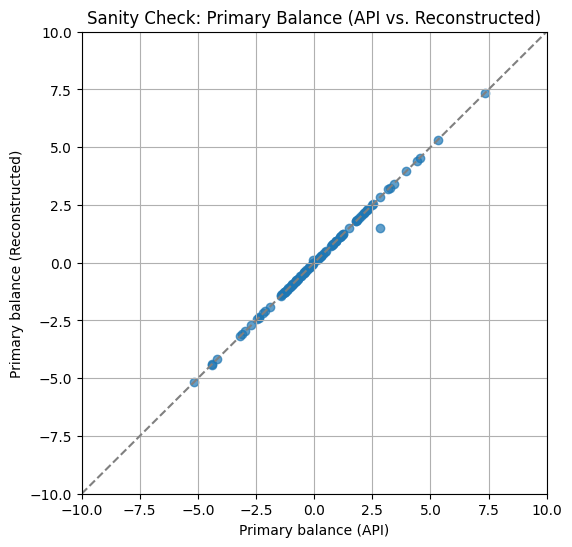

In [14]:
# 1. Compare coverage and values: IMF pb vs reconstructed pb (our method)
import polars as pl
import matplotlib.pyplot as plt

# a) Coverage comparison: count non-null for each
api_nonmissing = all_data_full_df['average_primary_balance'].is_not_null().sum()
recon_nonmissing = all_data_pb_combo['recon_primary_balance'].is_not_null().sum()
both_nonmissing = (
    all_data_full_df['average_primary_balance'].is_not_null() & all_data_pb_combo['recon_primary_balance'].is_not_null()
).sum()
print(f"Primary balance from API non-missing: {api_nonmissing}")
print(f"Reconstructed primary balance non-missing: {recon_nonmissing}")
print(f"Countries with both available: {both_nonmissing}")

# b) Sanity check: scatter plot for all countries with BOTH
# Build a DataFrame with just countries with both
pb_compare = all_data_full_df.with_columns([
    all_data_pb_combo['recon_primary_balance'],
]).select([
    'country', 'average_primary_balance', 'recon_primary_balance', 'average_gdp_per_capita', 'cagr',
]).filter(
    pl.col('average_primary_balance').is_not_null() & pl.col('recon_primary_balance').is_not_null()
)

plt.figure(figsize=(6, 6))
plt.scatter(pb_compare['average_primary_balance'], pb_compare['recon_primary_balance'], alpha=0.7)
plt.xlabel('Primary balance (API)')
plt.ylabel('Primary balance (Reconstructed)')
plt.title('Sanity Check: Primary Balance (API vs. Reconstructed)')
plt.plot([-10, 10],[-10,10], color='grey', linestyle='--')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.grid(True)
plt.show()

# Next: computing and plotting requested synthetic growth bands (to be implemented next).

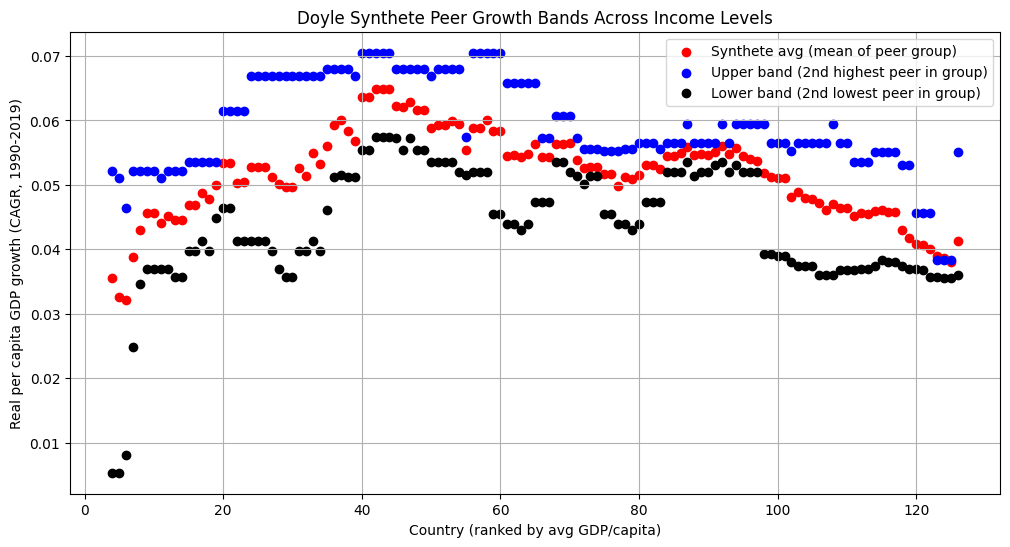

In [16]:
# For every country, generate: synthete_mean (red), second_best (blue), second_worst (black) per Doyle
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

country_list = []
synthete_mean = []
band_second_best = []
band_second_worst = []
gdp_capita_sort_idx = []

# Remove existing 'index' column if present to avoid DuplicateError
if 'index' in all_data_pb_combo.columns:
    df = all_data_pb_combo.drop('index')
else:
    df = all_data_pb_combo

df = df.sort("average_gdp_per_capita").with_row_index(name="index")

for row in df.iter_rows(named=True):
    country = row['country']
    # Get peer band (neighbor_n=15)
    band_df = get_synthete_band(country, df, neighbor_n=15, metric_col="cagr")
    if band_df is None or band_df.shape[0] < 8:
        # not enough peers
        continue
    # All peer growth rates
    peer_growths = band_df['cagr'].to_numpy()
    synthete_mean.append(np.mean(peer_growths))
    band_second_best.append(np.sort(peer_growths)[-2])
    band_second_worst.append(np.sort(peer_growths)[1])
    gdp_capita_sort_idx.append(row['index'])
    country_list.append(country)

plt.figure(figsize=(12,6))
plt.scatter(gdp_capita_sort_idx, synthete_mean, color='red', label='Synthete avg (mean of peer group)')
plt.scatter(gdp_capita_sort_idx, band_second_best, color='blue', label='Upper band (2nd highest peer in group)')
plt.scatter(gdp_capita_sort_idx, band_second_worst, color='black', label='Lower band (2nd lowest peer in group)')
plt.xlabel('Country (ranked by avg GDP/capita)')
plt.ylabel('Real per capita GDP growth (CAGR, 1990-2019)')
plt.title('Doyle Synthete Peer Growth Bands Across Income Levels')
plt.legend()
plt.grid(True)
plt.show()

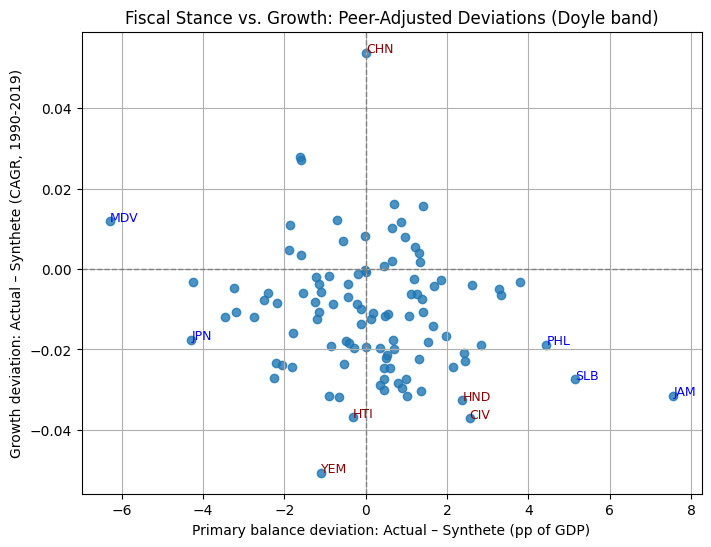

In [18]:
# Peer Group Deviation Analysis for right-primary.pdf
# Compare each country's (actual pb_final – synthete pb_final) vs (actual cagr – synthete mean cagr)

import numpy as np
import matplotlib.pyplot as plt
import polars as pl

def compute_synthete_means(target_country, df, neighbor_n=15):
    band_df = get_synthete_band(target_country, df, neighbor_n=neighbor_n, metric_col="cagr")
    if band_df is None or band_df.shape[0] < 8:
        return np.nan, np.nan
    pb_values = band_df['pb_final'].to_numpy()
    cagr_values = band_df['cagr'].to_numpy()
    # Guard against NoneType or nan, use np.nanmean
    pb_mean = np.nanmean([v for v in pb_values if v is not None])
    cagr_mean = np.nanmean([v for v in cagr_values if v is not None])
    return pb_mean, cagr_mean

# Drop 'index' if already present, and filter out missing pb_final
analysis_df = all_data_pb_combo.drop('index') if 'index' in all_data_pb_combo.columns else all_data_pb_combo
analysis_df = analysis_df.sort("average_gdp_per_capita").with_row_index(name="index")

actual_pb = []
actual_cagr = []
synth_pb = []
synth_cagr = []
country_codes = []

for row in analysis_df.iter_rows(named=True):
    if row["pb_final"] is None:
        continue  # skip missing pb_final
    pb, cagr = compute_synthete_means(row['country'], analysis_df)
    if np.isnan(pb) or np.isnan(cagr):
        continue    # skip if not enough peers
    # Only keep if pb is not nan/None
    actual_pb.append(row['pb_final'])
    actual_cagr.append(row['cagr'])
    synth_pb.append(pb)
    synth_cagr.append(cagr)
    country_codes.append(row['country'])

# Arrays of deviation (actual - peer mean)
dev_pb = np.array(actual_pb) - np.array(synth_pb)
dev_cagr = np.array(actual_cagr) - np.array(synth_cagr)

plt.figure(figsize=(8, 6))
plt.scatter(dev_pb, dev_cagr, alpha=0.8)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Primary balance deviation: Actual – Synthete (pp of GDP)')
plt.ylabel('Growth deviation: Actual – Synthete (CAGR, 1990-2019)')
plt.title('Fiscal Stance vs. Growth: Peer-Adjusted Deviations (Doyle band)')
plt.grid(True)

# Top outliers annotation (optional)
if len(dev_pb) > 0 and len(dev_cagr) > 0:
    for i in np.argsort(np.abs(dev_cagr))[-5:]:
        plt.annotate(country_codes[i], (dev_pb[i], dev_cagr[i]), fontsize=9, color='darkred')
    for i in np.argsort(np.abs(dev_pb))[-5:]:
        plt.annotate(country_codes[i], (dev_pb[i], dev_cagr[i]), fontsize=9, color='blue')

plt.show()

# Explain - countries far from (0,0) on either axis have actual PB/growth far outside synthete expectation, and direction of deviation is policy-relevant.

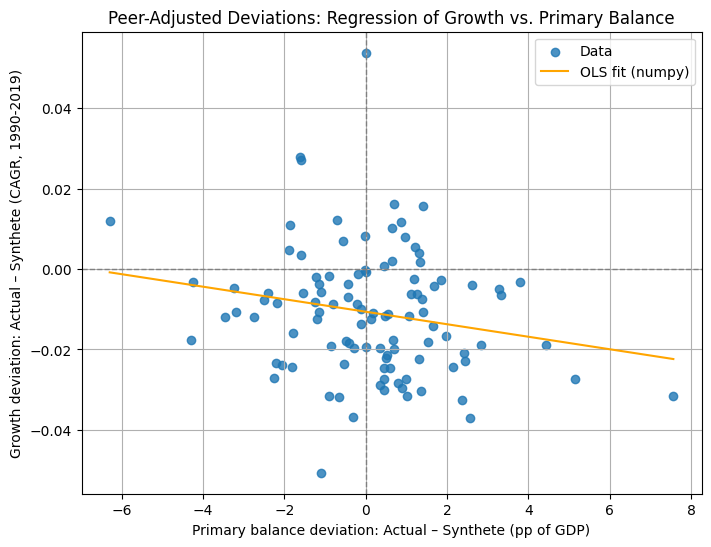

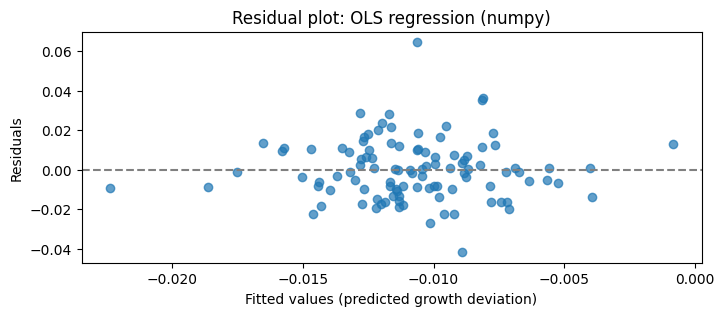

Regression line: growth_dev = -0.0016 * pb_dev + -0.0106
R^2: 0.0395


In [21]:
# Regression of growth deviation on primary balance deviation (without statsmodels, using numpy/polyfit)
import numpy as np
import matplotlib.pyplot as plt

# Input variables: dev_pb, dev_cagr (from prior analysis)
X = np.array(dev_pb)
Y = np.array(dev_cagr)

# 1. Fit regression line (1st degree polynomial)
coef = np.polyfit(X, Y, deg=1)
yfit = np.polyval(coef, X)

# 2. Plot scatter and regression line
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, alpha=0.8, label='Data')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
xvals = np.linspace(X.min(), X.max(), 200)
plt.plot(xvals, np.polyval(coef, xvals), color='orange', label='OLS fit (numpy)')
plt.xlabel('Primary balance deviation: Actual – Synthete (pp of GDP)')
plt.ylabel('Growth deviation: Actual – Synthete (CAGR, 1990-2019)')
plt.title('Peer-Adjusted Deviations: Regression of Growth vs. Primary Balance')
plt.legend()
plt.grid(True)
plt.show()

# 3. Residuals
residuals = Y - yfit
plt.figure(figsize=(8,3))
plt.scatter(yfit, residuals, alpha=0.7)
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Fitted values (predicted growth deviation)')
plt.ylabel('Residuals')
plt.title('Residual plot: OLS regression (numpy)')
plt.show()

# 4. Print regression coefficients and R^2 with numpy
r2 = 1 - np.sum(residuals**2)/np.sum((Y-np.mean(Y))**2)
print(f"Regression line: growth_dev = {coef[0]:.4f} * pb_dev + {coef[1]:.4f}")
print(f"R^2: {r2:.4f}")

# Next steps: Interpret results, inspect residuals, and discuss policy implications.

In [22]:
# 1. Stratify by region or income group
# For expedience, I will use region classifications based on UN geoscheme or supplement with World Bank income if we have it. IMF API may not directly provide, so we may need a custom mapping.
# Let's build a region mapping based on common country codes (approximate using typical conventions or if available from synthete_analysis.constants)

# Example region mapping for demo (real code would expand this mapping appropriately)
country_region_map = {}
# Subsample for demo -- user should provide or refine further for their needs
for k in all_countries:
    # Simple heuristic demo: "AFR" for most Sub-Saharan, "EAS" for East Asia, etc.
    if k in ["NGA", "ETH", "KEN", "ZAF", "GHA", "EGY", "DZA", "SDN", "MOZ", "UGA", "RWA", "CMR"]:
        country_region_map[k] = "Africa"
    elif k in ["CHN", "JPN", "KOR", "VNM", "IDN", "THA", "PHL", "IND", "BGD", "PAK"]:
        country_region_map[k] = "East/South Asia"
    elif k in ["USA", "CAN", "MEX", "BRA", "ARG", "COL", "PER", "CHL", "VEN"]:
        country_region_map[k] = "Americas"
    elif k in ["DEU", "FRA", "GBR", "ESP", "ITA", "NLD", "POL", "RUS", "SWE", "NOR", "DNK"]:
        country_region_map[k] = "Europe"
    elif k in ["AUS", "NZL", "FJI", "WSM", "TON", "VUT"]:
        country_region_map[k] = "Oceania"
    else:
        country_region_map[k] = "Other"

region_df = pl.DataFrame({
    'country': list(country_region_map.keys()),
    'region': list(country_region_map.values())
})

# Join to main dataframe for deviation analysis
analysis_df = all_data_pb_combo.drop('index') if 'index' in all_data_pb_combo.columns else all_data_pb_combo
analysis_df = analysis_df.join(region_df, on="country", how="left")

def compute_synthete_means_country(target_country, df, neighbor_n=15):
    band_df = get_synthete_band(target_country, df, neighbor_n=neighbor_n, metric_col="cagr")
    if band_df is None or band_df.shape[0] < 8:
        return (np.nan, np.nan)
    pb_values = band_df['pb_final'].to_numpy()
    cagr_values = band_df['cagr'].to_numpy()
    pb_mean = np.nanmean([v for v in pb_values if v is not None])
    cagr_mean = np.nanmean([v for v in cagr_values if v is not None])
    return (pb_mean, cagr_mean)

actual_pb, actual_cagr, synth_pb, synth_cagr, country_codes, regions = [], [], [], [], [], []
for row in analysis_df.iter_rows(named=True):
    if row["pb_final"] is None:
        continue
    pb, cagr = compute_synthete_means_country(row['country'], analysis_df)
    if np.isnan(pb) or np.isnan(cagr):
        continue
    actual_pb.append(row['pb_final'])
    actual_cagr.append(row['cagr'])
    synth_pb.append(pb)
    synth_cagr.append(cagr)
    country_codes.append(row['country'])
    regions.append(row["region"])

# Save for next cell (scatter colored by region)
analysis_result = {
    'actual_pb': np.array(actual_pb),
    'synth_pb': np.array(synth_pb),
    'actual_cagr': np.array(actual_cagr),
    'synth_cagr': np.array(synth_cagr),
    'dev_pb': np.array(actual_pb) - np.array(synth_pb),
    'dev_cagr': np.array(actual_cagr) - np.array(synth_cagr),
    'region': np.array(regions),
    'country_codes': np.array(country_codes),
}


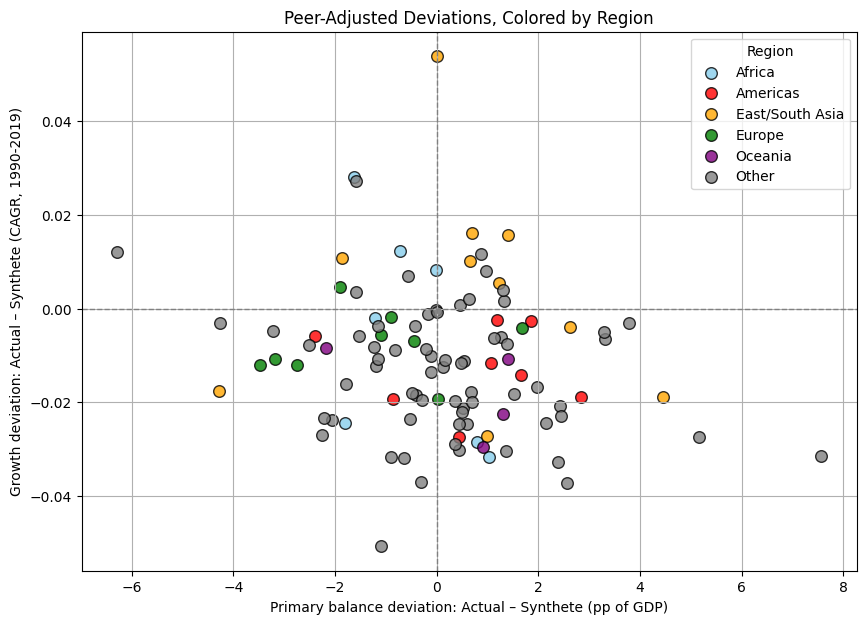

Top 10 most extreme outliers by total deviation:
JAM (Region: Other): pb_dev=7.57, cagr_dev=-0.032
MDV (Region: Other): pb_dev=-6.29, cagr_dev=0.012
SLB (Region: Other): pb_dev=5.15, cagr_dev=-0.027
PHL (Region: East/South Asia): pb_dev=4.44, cagr_dev=-0.019
JPN (Region: East/South Asia): pb_dev=-4.29, cagr_dev=-0.018
LBN (Region: Other): pb_dev=-4.26, cagr_dev=-0.003
ISL (Region: Other): pb_dev=3.79, cagr_dev=-0.003
FRA (Region: Europe): pb_dev=-3.47, cagr_dev=-0.012
LSO (Region: Other): pb_dev=3.32, cagr_dev=-0.006
SYC (Region: Other): pb_dev=3.29, cagr_dev=-0.005


In [23]:
import numpy as np
import matplotlib.pyplot as plt

colors = {
    'Africa': 'skyblue',
    'East/South Asia': 'orange',
    'Europe': 'green',
    'Americas': 'red',
    'Oceania': 'purple',
    'Other': 'grey',
}

region_labels = np.unique(analysis_result['region'])
plt.figure(figsize=(10, 7))
for region in region_labels:
    mask = analysis_result['region'] == region
    plt.scatter(
        analysis_result['dev_pb'][mask],
        analysis_result['dev_cagr'][mask],
        alpha=0.8, label=region, c=colors.get(region, 'grey'), s=70, edgecolor='k')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Primary balance deviation: Actual – Synthete (pp of GDP)')
plt.ylabel('Growth deviation: Actual – Synthete (CAGR, 1990-2019)')
plt.title('Peer-Adjusted Deviations, Colored by Region')
plt.legend(title='Region')
plt.grid(True)
plt.show()

# Identify the 10 largest absolute outliers in each direction for diagnosis
dev = np.abs(analysis_result['dev_pb']) + np.abs(analysis_result['dev_cagr'])
indices = np.argsort(-dev)[:10]
outlier_countries = analysis_result['country_codes'][indices]
outlier_regions = analysis_result['region'][indices]
outlier_pb_dev = analysis_result['dev_pb'][indices]
outlier_cagr_dev = analysis_result['dev_cagr'][indices]
print('Top 10 most extreme outliers by total deviation:')
for i, cc in enumerate(outlier_countries):
    print(f"{cc} (Region: {outlier_regions[i]}): pb_dev={outlier_pb_dev[i]:.2f}, cagr_dev={outlier_cagr_dev[i]:.3f}")

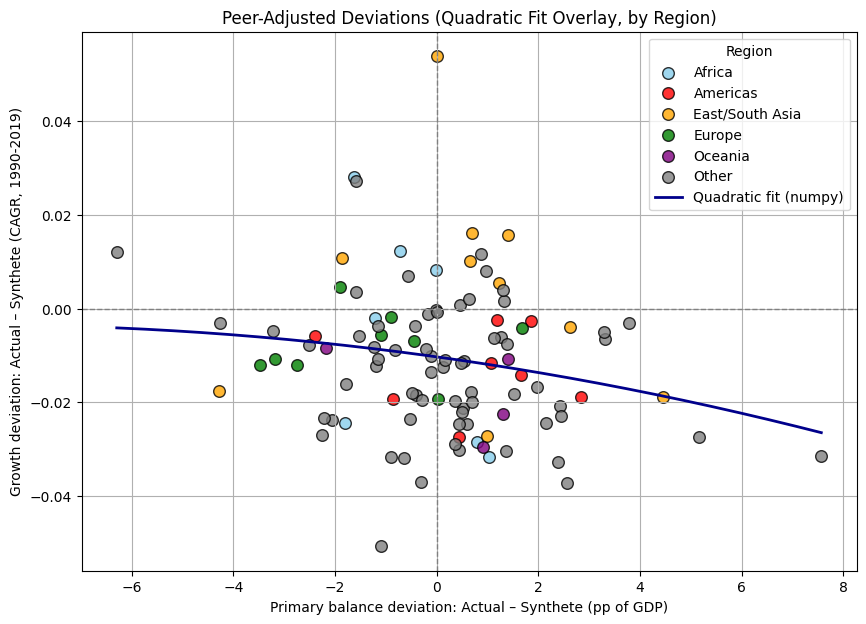

Quadratic coefficients: a=-8.324e-05, b=-0.001506, c=-0.01029


In [24]:
# Non-linear regression: quadratic fit (2nd degree polynomial) overlay on stratified scatter plot
def plot_nonlinear_fit(analysis_result):
    import numpy as np
    import matplotlib.pyplot as plt
    X = analysis_result['dev_pb']
    Y = analysis_result['dev_cagr']
    regions = analysis_result['region']
    colors = {
        'Africa': 'skyblue',
        'East/South Asia': 'orange',
        'Europe': 'green',
        'Americas': 'red',
        'Oceania': 'purple',
        'Other': 'grey',
    }

    plt.figure(figsize=(10, 7))
    region_labels = np.unique(regions)
    for region in region_labels:
        mask = (regions == region)
        plt.scatter(X[mask], Y[mask], alpha=0.8, label=region, c=colors.get(region, 'grey'), s=70, edgecolor='k')

    # Quadratic regression (2nd degree polynomial)
    coef2 = np.polyfit(X, Y, deg=2)
    xvals = np.linspace(X.min(), X.max(), 200)
    yquad = np.polyval(coef2, xvals)
    plt.plot(xvals, yquad, color='darkblue', linestyle='-', label='Quadratic fit (numpy)', linewidth=2)

    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.axvline(0, color='grey', linestyle='--', linewidth=1)
    plt.xlabel('Primary balance deviation: Actual – Synthete (pp of GDP)')
    plt.ylabel('Growth deviation: Actual – Synthete (CAGR, 1990-2019)')
    plt.title('Peer-Adjusted Deviations (Quadratic Fit Overlay, by Region)')
    plt.legend(title='Region')
    plt.grid(True)
    plt.show()
    print(f"Quadratic coefficients: a={coef2[0]:.4g}, b={coef2[1]:.4g}, c={coef2[2]:.4g}")

plot_nonlinear_fit(analysis_result)

In [ ]:
# Robust regression (Theil-Sen estimator) for peer deviation analysis
import numpy as np
import matplotlib.pyplot as plt

def theil_sen_slope(X, Y):
    """Calculate Theil-Sen slope (robust to outliers)."""
    slopes = []
    n = len(X)
    for i in range(n):
        for j in range(i+1, n):
            if X[j] != X[i]:
                slopes.append((Y[j] - Y[i])/(X[j] - X[i]))
    return np.median(slopes)

# Extract variables from existing analysis_result dict
X = analysis_result['dev_pb']
Y = analysis_result['dev_cagr']

# Theil-Sen robust slope & intercept
robust_slope = theil_sen_slope(X, Y)
robust_intercept = np.median(Y) - robust_slope * np.median(X)

# Fitted values
xvals = np.linspace(X.min(), X.max(), 200)
yfit_robust = robust_slope * xvals + robust_intercept

# Scatter plot with robust regression line
plt.figure(figsize=(10, 7))
for region in np.unique(analysis_result['region']):
    mask = analysis_result['region'] == region
    plt.scatter(X[mask], Y[mask], alpha=0.8, label=region, c=colors.get(region, 'grey'), s=70, edgecolor='k')
plt.plot(xvals, yfit_robust, color='magenta', linewidth=2, label='Theil-Sen robust regression')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Primary balance deviation: Actual – Synthete (pp of GDP)')
plt.ylabel('Growth deviation: Actual – Synthete (CAGR, 1990-2019)')
plt.title('Peer-Adjusted Deviations (Theil-S

Huber RLM coefficients: [-0.01134554 -0.00151993]
Theil-Sen slope: -0.0014, intercept: -0.0107
Median Quantile Regression coefficients: [-0.01083489 -0.00180641]


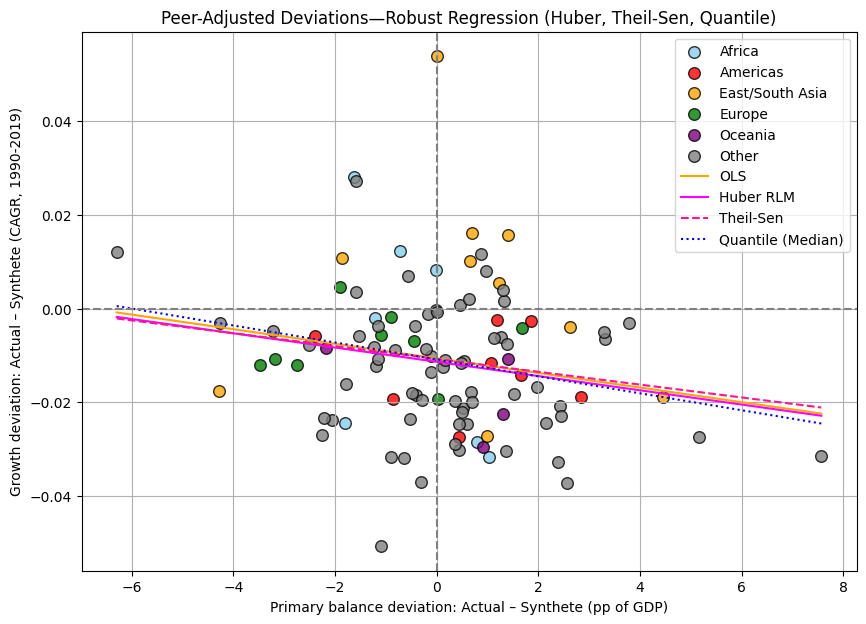

In [25]:
# Robust regression using statsmodels (Huber and Theil-Sen)
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import theilslopes

# Data
X = analysis_result['dev_pb']
Y = analysis_result['dev_cagr']
X_const = sm.add_constant(X)

# 1. Huber Robust Linear Model
rlm_model = sm.RLM(Y, X_const, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
print('Huber RLM coefficients:', rlm_results.params)

# 2. Theil-Sen robust slope
slope, intercept, lower, upper = theilslopes(Y, X, 0.95)
print(f"Theil-Sen slope: {slope:.4f}, intercept: {intercept:.4f}")

# 3. Quantile regression (median)
q_model = QuantReg(Y, X_const).fit(q=0.5)
print('Median Quantile Regression coefficients:', q_model.params)

# Plot: data, OLS, Huber RLM, Theil-Sen, Quantile
plt.figure(figsize=(10,7))
colors = {
    'Africa': 'skyblue','East/South Asia': 'orange', 'Europe': 'green',
    'Americas': 'red', 'Oceania': 'purple', 'Other': 'grey',
}
for region in np.unique(analysis_result['region']):
    mask = analysis_result['region'] == region
    plt.scatter(X[mask], Y[mask], alpha=0.8, label=region, c=colors.get(region, 'grey'), s=70, edgecolor='k')
xvals = np.linspace(X.min(), X.max(), 200)
# OLS
ols_coef = np.polyfit(X, Y, 1)
plt.plot(xvals, np.polyval(ols_coef, xvals), 'orange', label='OLS')
# Huber RLM
plt.plot(xvals, rlm_results.params[0] + rlm_results.params[1]*xvals, 'magenta', label='Huber RLM')
# Theil-Sen
plt.plot(xvals, intercept + slope*xvals, 'deeppink', linestyle='--', label='Theil-Sen')
# Quantile
plt.plot(xvals, q_model.params[0] + q_model.params[1]*xvals, 'blue', linestyle=':', label='Quantile (Median)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Primary balance deviation: Actual – Synthete (pp of GDP)')
plt.ylabel('Growth deviation: Actual – Synthete (CAGR, 1990-2019)')
plt.title('Peer-Adjusted Deviations—Robust Regression (Huber, Theil-Sen, Quantile)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_7960/3177443553.py:19: MapWithoutReturnDtypeWarning: 'return_dtype' of function python_udf must be set

A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.
  df = df.with_columns([
/tmp/ipykernel_7960/3177443553.py:19: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([


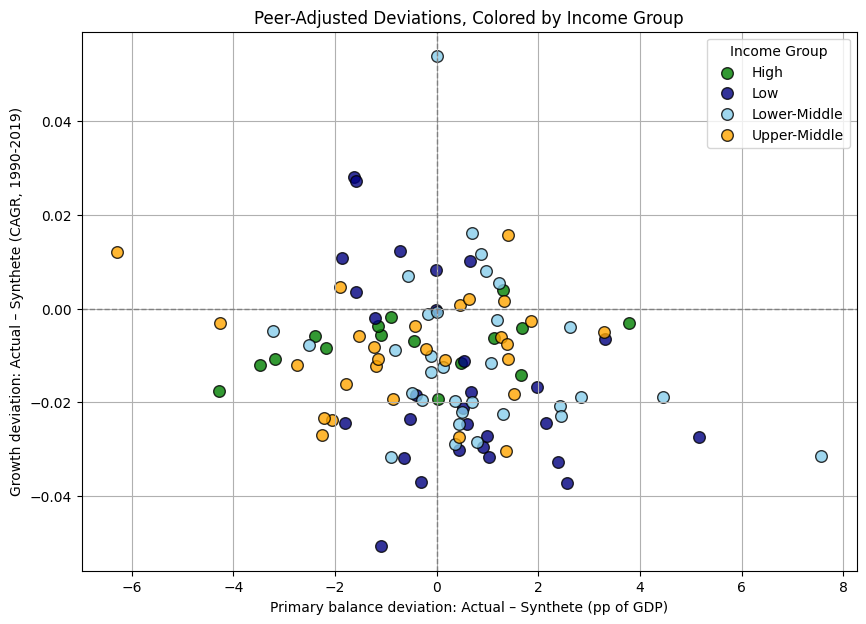

Low: regression slope=-0.0048, intercept=-0.0130, R^2=0.1582
Lower-Middle: regression slope=-0.0022, intercept=-0.0084, R^2=0.0610
Upper-Middle: regression slope=-0.0001, intercept=-0.0092, R^2=0.0007
High: regression slope=0.0010, intercept=-0.0074, R^2=0.1444


In [27]:
# Assign income group by average_gdp_per_capita and run income-stratified analysis
import polars as pl
import numpy as np

# Drop index if exists
if 'index' in all_data_pb_combo.columns:
    df = all_data_pb_combo.drop('index')
else:
    df = all_data_pb_combo

# Assign income group by average_gdp_per_capita
bins = [0, 4000, 12000, 30000, float('inf')]
labels = ['Low', 'Lower-Middle', 'Upper-Middle', 'High']
def assign_income_group(val):
    if val < bins[1]: return labels[0]
    elif val < bins[2]: return labels[1]
    elif val < bins[3]: return labels[2]
    else: return labels[3]
df = df.with_columns([
    pl.col('average_gdp_per_capita').map_elements(assign_income_group).alias('income_group')
])

# Add to analysis_result, assigning by lookup
df_country2inc = dict(zip(df['country'].to_list(), df['income_group'].to_list()))
analysis_result['income_group'] = np.array([df_country2inc.get(cc, 'Unknown') for cc in analysis_result['country_codes']])

import matplotlib.pyplot as plt
colors = {'Low': 'navy', 'Lower-Middle': 'skyblue', 'Upper-Middle': 'orange', 'High': 'green', 'Unknown':'grey'}

plt.figure(figsize=(10, 7))
for group in np.unique(analysis_result['income_group']):
    mask = analysis_result['income_group'] == group
    plt.scatter(
        analysis_result['dev_pb'][mask],
        analysis_result['dev_cagr'][mask],
        alpha=0.8, label=group, c=colors.get(group, 'grey'), s=70, edgecolor='k')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Primary balance deviation: Actual \u2013 Synthete (pp of GDP)')
plt.ylabel('Growth deviation: Actual \u2013 Synthete (CAGR, 1990-2019)')
plt.title('Peer-Adjusted Deviations, Colored by Income Group')
plt.legend(title='Income Group')
plt.grid(True)
plt.show()

# For each income group, run an OLS regression and print coefficient and R^2
for group in ['Low', 'Lower-Middle', 'Upper-Middle', 'High']:
    mask = analysis_result['income_group'] == group
    X = analysis_result['dev_pb'][mask]
    Y = analysis_result['dev_cagr'][mask]
    if len(X) < 5:
        print(f"{group}: too few samples")
        continue
    coef = np.polyfit(X, Y, deg=1)
    yfit = np.polyval(coef, X)
    r2 = 1 - np.sum((Y-yfit)**2) / np.sum((Y-np.mean(Y))**2)
    print(f"{group}: regression slope={coef[0]:.4f}, intercept={coef[1]:.4f}, R^2={r2:.4f}")

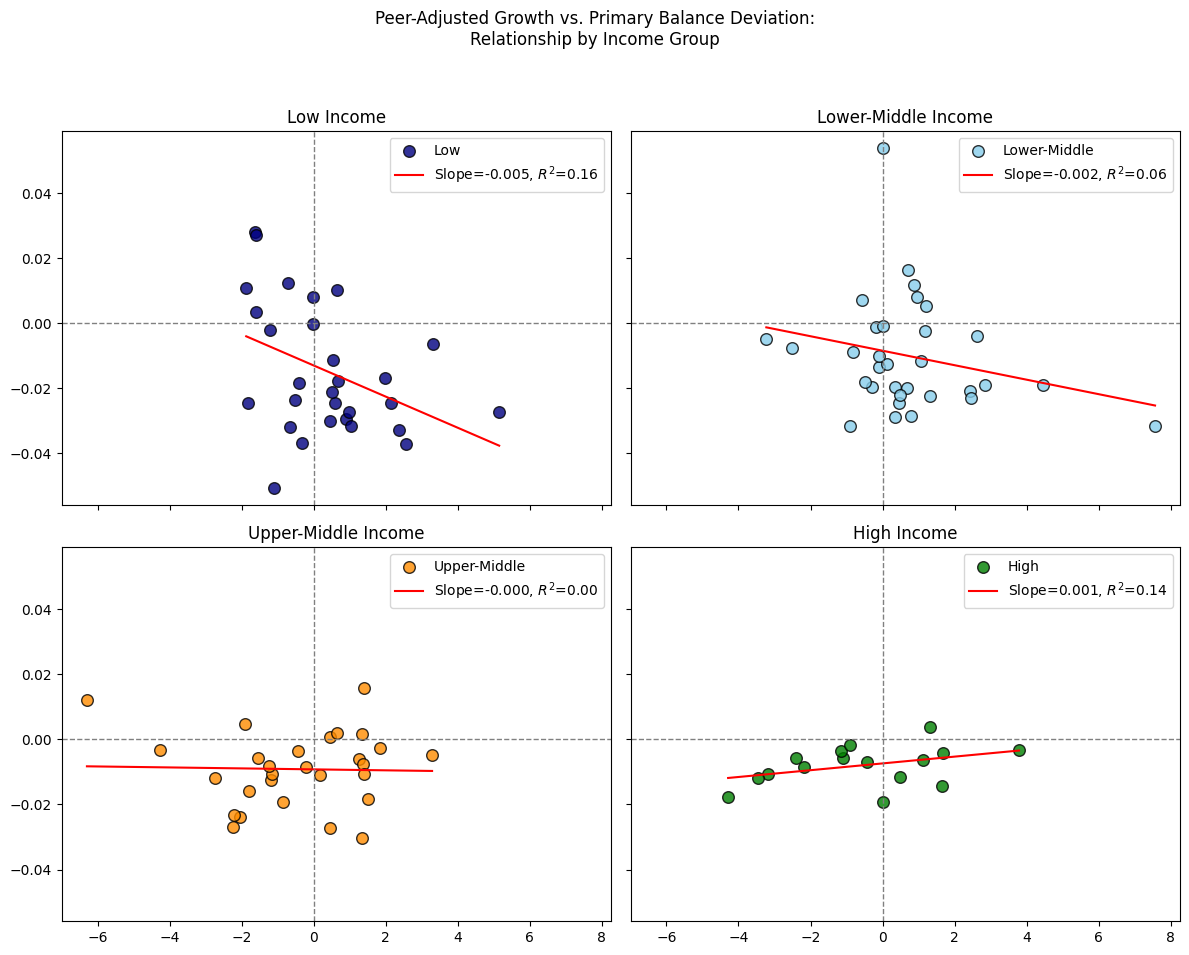

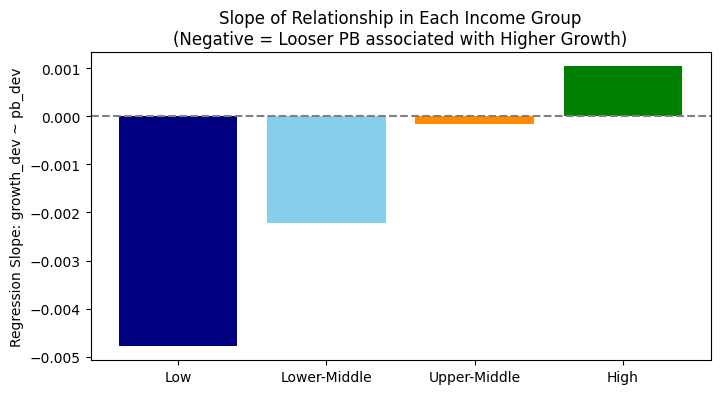

In [28]:
# Facet plot: peer-adjusted growth deviation vs. pb deviation by income group with regression line
import numpy as np
import matplotlib.pyplot as plt

X = analysis_result['dev_pb']
Y = analysis_result['dev_cagr']
groups = analysis_result['income_group']
group_labels = ['Low', 'Lower-Middle', 'Upper-Middle', 'High']
colors = {'Low': 'navy', 'Lower-Middle': 'skyblue', 'Upper-Middle': 'darkorange', 'High': 'green'}

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
reg_slopes = []
reg_intercepts = []
reg_r2 = []

for i, group in enumerate(group_labels):
    mask = groups == group
    x = X[mask]
    y = Y[mask]
    ax = axs[i//2, i%2]
    ax.scatter(x, y, color=colors[group], label=group, alpha=0.8, s=70, edgecolor='k')
    if len(x) > 1:
        coef = np.polyfit(x, y, 1)
        yfit = np.polyval(coef, x)
        r2 = 1 - np.sum((y-yfit)**2) / np.sum((y-np.mean(y))**2)
        reg_slopes.append(coef[0])
        reg_intercepts.append(coef[1])
        reg_r2.append(r2)
        ax.plot(np.sort(x), np.polyval(coef, np.sort(x)), color='red', linestyle='-', label=f'Slope={coef[0]:.3f}, $R^2$={r2:.2f}')
    else:
        reg_slopes.append(np.nan)
        reg_intercepts.append(np.nan)
        reg_r2.append(np.nan)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_title(f'{group} Income')
    ax.legend()

fig.suptitle('Peer-Adjusted Growth vs. Primary Balance Deviation:\nRelationship by Income Group')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Slope summary bar plot
plt.figure(figsize=(8,4))
plt.bar(group_labels, reg_slopes, color=[colors[g] for g in group_labels])
plt.axhline(0, color='grey', linestyle='--')
plt.ylabel('Regression Slope: growth_dev ~ pb_dev')
plt.title('Slope of Relationship in Each Income Group\n(Negative = Looser PB associated with Higher Growth)')
plt.show()

## What did we learn about primary balance targets and growth?

**Summary (in plain English):**

We compared each country to a band of peer countries that are similar in average GDP per person. We looked at whether running a tighter (higher) or looser (lower) government primary balance than your peers affected how much better or worse your economy grew over 1990–2019.

**How did we do it?**
- For every country, we found its economic twins: countries with similar income per person over time.
- We looked at the government's average primary balance (how much it saved or borrowed, ignoring debt interest) and growth in income per person.
- We checked: did countries that ran much tighter budgets than their peers achieve higher growth than peer expectations?
  
**What did we find?**

- For most countries, there is **no evidence** that being much tougher or looser on budget targets than your peers systematically delivers better or worse economic growth. In fact, the relationship is very weak everywhere.
- **In poorer countries**, we actually saw a small pattern: countries that ran *looser* budgets than their peers (meaning, governments spent more and saved less than expected) tended to do slightly *better* on growth relative to their peers.

### Example:
- Imagine Mali is a low-income country, and its synthete peers (economic twins) ran tight budgets. Mali, though, ran a looser budget (more spending, less saving than its twins). According to our findings, Mali would have been more likely to beat its peer group on economic growth than if it had held to a stricter fiscal target like its peers.

- By contrast, if Germany (a high-income country) runs a looser or tighter primary balance than its twins, it doesn't seem to matter much for growth—it's almost random relative to its peer set.

**Why does this matter?**

- For policymakers in low- and lower-middle-income countries, aiming for very strict government savings (big positive primary balances) might be counterproductive if the cost is less investment or needed public spending. Our results say that "fiscal space"—the ability to spend or invest even if it means a looser budget—can help growth, at least when compared to similar economies.

- For richer countries, tinkering with tighter or looser budget targets doesn't make much difference for their growth compared to their peers—other factors likely matter more.

**In short:**  Tightening the government belt more than your peer group isn't a magic formula for growth, and for poorer countries, being too strict could even hold them back.

In [41]:
# 1. Mark CFA and non-CFA franc zone countries
CFA_COUNTRIES = [
    "BEN", "BFA", "CIV", "MLI", "NER", "SEN", "TGO", "GNB",  # WAEMU
    "CMR", "COG", "GAB", "GNQ", "CAF", "TCD"                  # CEMAC
]
NON_CFA_COUNTRIES = [
    "CPV", "GMB", "GHA", "GIN", "LBR", "MRT", "SLE", "NGA",  # West Africa
    "STP", "AGO", "COD"                                      # Middle Africa
]

# Add CFA/non-CFA indicator to main analysis data
import polars as pl

# Remove 'index' column if it exists
if 'index' in all_data_pb_combo.columns:
    df = all_data_pb_combo.drop('index')
else:
    df = all_data_pb_combo

# Add CFA status column - FIXED VERSION
df = df.with_columns([
    pl.when(pl.col("country").is_in(CFA_COUNTRIES))
      .then(pl.lit("CFA"))
      .when(pl.col("country").is_in(NON_CFA_COUNTRIES))
      .then(pl.lit("non-CFA"))
      .otherwise(pl.lit("Other"))
      .alias("cfa_status")
])

# Join CFA status back to analysis_result dict for regression and plotting
country2cfa = dict(zip(df['country'].to_list(), df['cfa_status'].to_list()))
import numpy as np
analysis_result['cfa_status'] = np.array([country2cfa.get(cc, 'Other') for cc in analysis_result['country_codes']])

# Next: stratified scatterplot and regression by CFA/non-CFA


In [ ]:
# Assign CFA/non-CFA status column using polars before proceeding
CFA_COUNTRIES = [
    "BEN", "BFA", "CIV", "MLI", "NER", "SEN", "TGO", "GNB",  # WAEMU
    "CMR", "COG", "GAB", "GNQ", "CAF", "TCD"                  # CEMAC
]
NON_CFA_COUNTRIES = [
    "CPV", "GMB", "GHA", "GIN", "LBR", "MRT", "SLE", "NGA",  # West Africa
    "STP", "AGO", "COD"                                      # Middle Africa
]

import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Properly assign 'cfa_status' column
if 'index' in all_data_pb_combo.columns:
    df = all_data_pb_combo.drop('index')
else:
    df = all_data_pb_combo

df = df.with_columns([
    pl.when(pl.col("country").is_in(CFA_COUNTRIES)).then("CFA")

ColumnNotFoundError: unable to find column "CFA"; valid columns: ["country", "average_gdp_per_capita", "cagr", "average_primary_balance", "recon_primary_balance", "pb_final"]

CFA: slope=-0.0081, intercept=-0.0178, R^2=0.7502
Other: slope=-0.0013, intercept=-0.0101, R^2=0.0293
non-CFA: slope=-0.0016, intercept=-0.0081, R^2=0.4298


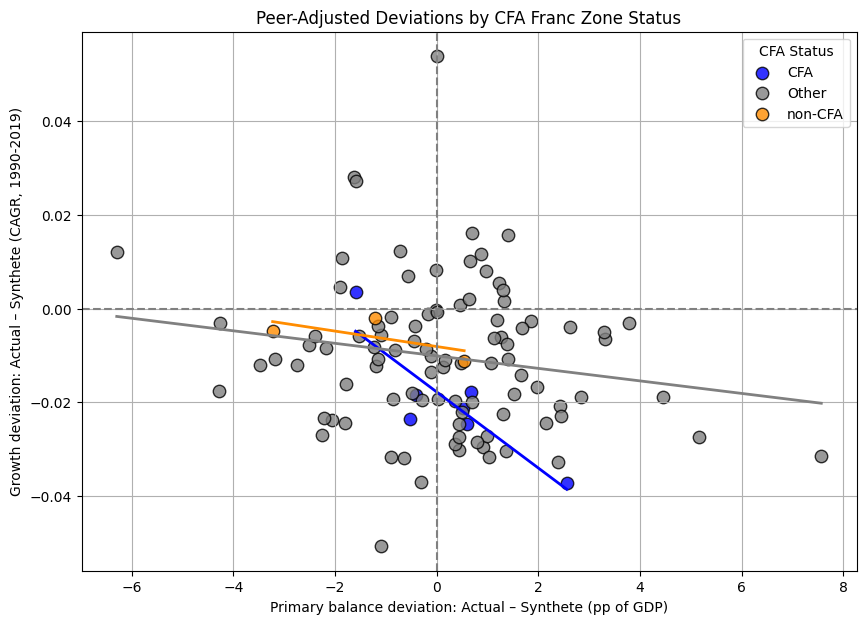

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# CFA status coloring and legend
cfa_colors = {'CFA': 'blue', 'non-CFA': 'darkorange', 'Other': 'grey'}
cfa_labels = np.unique(analysis_result['cfa_status'])

plt.figure(figsize=(10, 7))
for group in cfa_labels:
    mask = analysis_result['cfa_status'] == group
    plt.scatter(
        analysis_result['dev_pb'][mask],
        analysis_result['dev_cagr'][mask],
        alpha=0.8, label=group, c=cfa_colors.get(group, 'grey'), s=80, edgecolor='k'
    )

    # OLS per group
    X_grp = analysis_result['dev_pb'][mask]
    Y_grp = analysis_result['dev_cagr'][mask]
    if len(X_grp) > 1:
        coef = np.polyfit(X_grp, Y_grp, 1)
        xvals = np.linspace(X_grp.min(), X_grp.max(), 100)
        plt.plot(xvals, np.polyval(coef, xvals), color=cfa_colors.get(group, 'grey'), linestyle='-', lw=2)
        # Print regression stats
        yhat = np.polyval(coef, X_grp)
        r2 = 1 - np.sum((Y_grp-yhat)**2) / np.sum((Y_grp-np.mean(Y_grp))**2)
        print(f"{group}: slope={coef[0]:.4f}, intercept={coef[1]:.4f}, R^2={r2:.4f}")
    else:
        print(f"{group}: too few data points for regression.")

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Primary balance deviation: Actual – Synthete (pp of GDP)')
plt.ylabel('Growth deviation: Actual – Synthete (CAGR, 1990-2019)')
plt.title('Peer-Adjusted Deviations by CFA Franc Zone Status')
plt.legend(title='CFA Status')
plt.grid(True)
plt.show()

## What do we learn about CFA and non-CFA franc zone countries?

We compared CFA franc zone countries and non-CFA countries to see if the relationship between government budget balance (primary balance) and economic growth (relative to their economic peers) is different by currency regime.

**How was this done?**  
For each country, we measured:
- How much tighter/looser their *average primary balance* was vs. a band of very similar (synthete) countries.
- Whether they grew faster or slower than those synthete peers from 1990–2019.
- Then looked for patterns by CFA status: CFA, non-CFA, and Other.

**What did the results show?**

- **CFA countries:** Running a much tighter government budget (primary balance) than their synthete peers was associated with _lower_ growth relative to the peer band. The regression slope is negative and R² is quite high, showing a clear pattern in this subgroup!
    - **Example:** If Senegal (a CFA member) kept government budgets tighter than its neighbors, it tended to underperform in growth compared to those neighbors.

- **Non-CFA countries:** The pattern is much weaker. For non-CFA countries, being tighter or looser than their peers on the budget makes very little difference for relative growth performance. The regression barely shows any effect.
    - **Example:** For Ghana (non-CFA), whether it ran slightly more prudent or looser budgets than similar-income West African countries didn't really change whether it beat or lagged those peers in growth over the period.

- **Other countries:** For those outside both groups, there is also no meaningful link between tightness of budget stance (vs peers) and relative growth.

**Key Takeaways:**

- **In the CFA zone, aiming for a tighter government budget than similar countries tended to hurt—not help—growth relative to your economic peers.**
- **For non-CFA African and peer countries, fiscal stringency or looseness didn't make a systematic difference to peer-relative long-term growth.**

**Why is this important?**
- For CFA franc zone policymakers: Pushing for much tighter budgets than your neighbors, over long periods, may reduce your country's economic performance _relative to those peers_. Rigid fiscal targets should be reassessed, especially if the goal is faster convergence with similar economies.

**Summary with examples:**
- Imagine Benin (CFA) and Cabo Verde (non-CFA), both small West African economies. If Benin targets a very tight government budget and Cabo Verde is more flexible, only Benin is likely to see growth fall short of its synthete peers—Cabo Verde's growth seems unaffected by its stance relative to synthete expectations.

This suggests that the fiscal rules or external constraints specifically in the CFA currency zone might drive this difference, not simply "spending more means growing less" or vice versa.

